### Coursework 2

In this coursework you will be aiming to complete two classification tasks. 
Both the classification tasks relate to text classification tasks. 

One task is to be solved using Support Vector Machines. The other has to be solved using Boosting.

The specific tasks and the marking for the various tasks are provided in the notebook. Each task is expected to be accompanied by a lab-report. Each task can have a concise lab report that is maximum of one page in an A4 size. You will be expected to submit your Jupyter Notebook and all lab reports as a single zip file. You could have additional functions implemented that you require for carrying out each task.


#### Task 1

In this task, you need to obtain sentiment analysis for the provided dataset. The dataset consists of movie reviews with the sentiments being provided. The sentiments are either positive or negative. You need to train an SVM based classifier to obtain train and check on the sample test dataset provided. The method will be evaluated also against an external test set. Please do not hardcode any dimensions or number of samples while writing the code. It should be possible to automate the testing and hardcoding values does not allow for automated testing. 

You are allowed to use scikit-learn to implement the SVM. However, you are expected to write your own kernels.

You are allowed to use the existing library functions such as scikit-learn or numpy for obtaining the SVM. The main idea is to analyse the dataset using different kind of kernels. You are also supposed to write your own custom text kernels. Refer to the documentation provided [here](https://scikit-learn.org/stable/modules/svm.html) at 1.4.6.2 and an example [here](https://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html) for writing your own kernels.

Details regarding the marking have been provided in the coursework specification file. Ensure that the code can be run with different test files. 

#### Process the text and obtain a bag of words-based features 

In [2]:
import numpy as np
import nltk
import pandas as pd


def load_data(train_file, test_file):
    # Read the CSV file and extract Bag of Words Features
    train_df = pd.read_csv(train_file)
    test_df = pd.read_csv(test_file)
    raw_train_x = list(train_df.review)
    train_y = list(map((lambda x : 0 if x == 'negative' else 1), train_df.sentiment))
    
    raw_test_x = list(test_df.review)
    test_y = list(map((lambda x : 0 if x == 'negative' else 1), test_df.sentiment))
    
    return raw_train_x, np.array(train_y), raw_test_x, np.array(test_y)

def extract_bag_of_words_train_test(train_file, test_file):
    raw_train_x, train_y, raw_test_x, test_y = load_data(train_file, test_file)
    
    train_x = get_embeddings(raw_train_x)
    test_x  = get_embeddings(raw_test_x)
    return (train_x, train_y, test_x, test_y)

def get_embeddings(reviews):
    from sentence_transformers import SentenceTransformer
    embedding_length = 128
    embeddings = []
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')
    model.max_seq_length = embedding_length
    
    for review in reviews:
        if len(review.split(' ')) <= embedding_length:
            embeddings.append(model.encode(review))
        else:
            ## If the review is longer than the maximum supported sequence length then embed in chunks and average
            ## chunks overlap by 15 words to preserve some semantic continuity between chunks
            split_review = review.split(' ')
            split_review = [' '.join(split_review[i:i+embedding_length+15]) for i in range(0,len(split_review),embedding_length-15)]
            split_embeddings = []
            split_lens = []
            for split in split_review:
                split_lens.append(len(split))
                embedding = model.encode(split)
                split_embeddings.append(embedding)
            embeddings.append(np.average(np.array(split_embeddings), axis = 0, weights = split_lens))
    return np.array(embeddings)

embeddings already retrieved, skipping
hyper-params already optimised, skipping
Hyper-Parameters
RBF: ((0.9000000000000001, 2.2857142857142856), 0.8206666666666667)
Poly: ((0.7, 2.2857142857142856, 2.0), 0.82)
Linear: ((0.7, 3.0, 3.0, 1.0, 3.0, 5.0, 1.0), 0.8346666666666668)


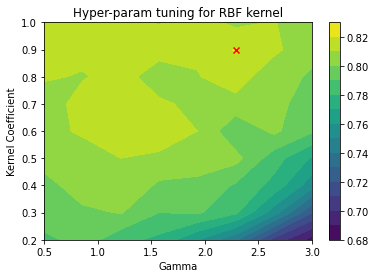

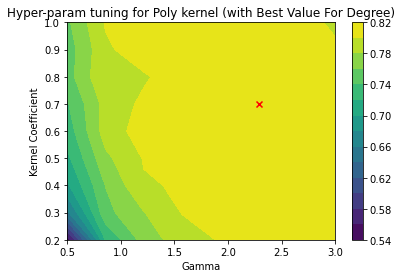

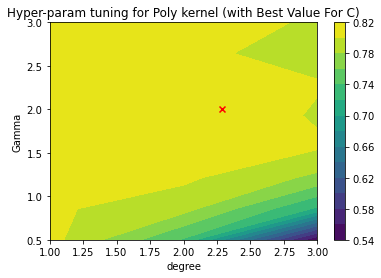

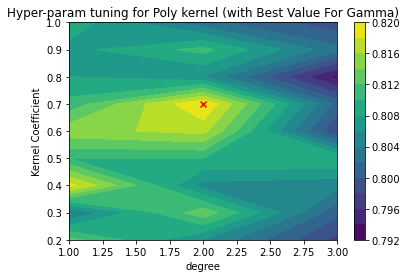

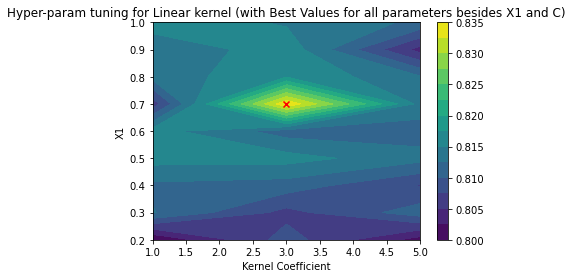

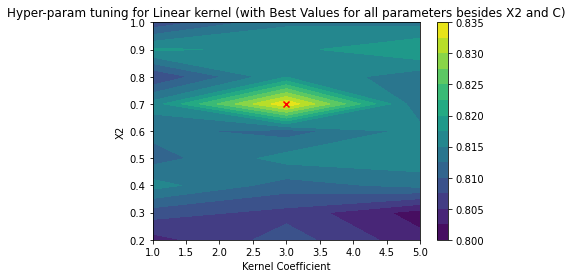

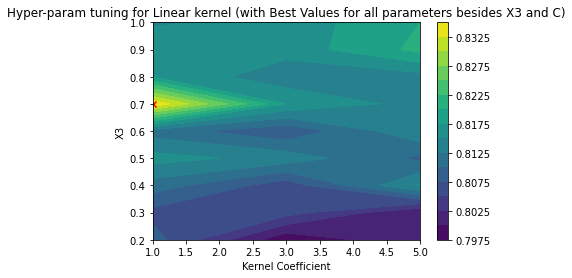

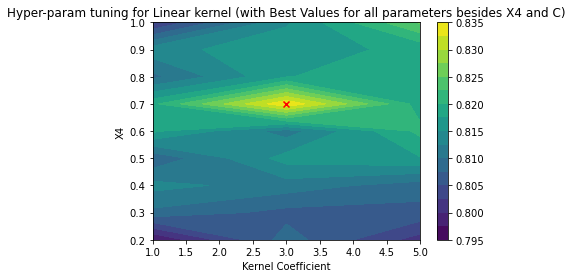

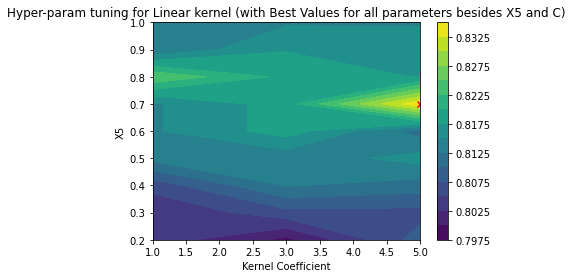

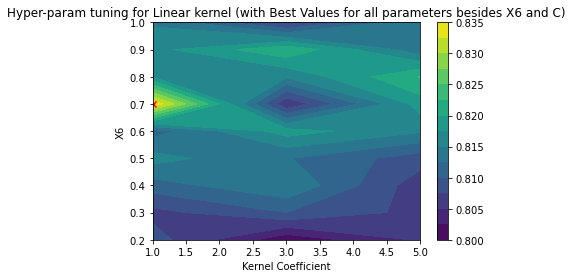

Correct Predicitons: TP: 744, TN: 719
Incorrect Predictions: FP: 12, FN: 25
 metrics: {'accuracy': 0.9753333333333334, 'f1_score': 0.9757377049180328, 'sensitivity': 0.9674902470741222, 'false_negative_rate': 0.032509752925877766, 'false_positive_rate': 0.016415868673050615, 'specificity': 0.9835841313269493}
Correct Predicitons: TP: 747, TN: 726
Incorrect Predictions: FP: 5, FN: 22
 metrics: {'accuracy': 0.982, 'f1_score': 0.9822485207100592, 'sensitivity': 0.9713914174252276, 'false_negative_rate': 0.02860858257477243, 'false_positive_rate': 0.006839945280437756, 'specificity': 0.9931600547195623}
Correct Predicitons: TP: 663, TN: 637
Incorrect Predictions: FP: 94, FN: 106
 metrics: {'accuracy': 0.8666666666666667, 'f1_score': 0.8689384010484927, 'sensitivity': 0.8621586475942783, 'false_negative_rate': 0.1378413524057217, 'false_positive_rate': 0.12859097127222982, 'specificity': 0.8714090287277702}


In [97]:
import numpy as np
from sklearn import svm
import itertools

class SVMClassifier:
    def __init__(self):
        
        #implement initialisation
        #self.some_paramter=1
        self.clf = svm.SVC(decision_function_shape='ovr')
        self.clf.kernel = 'rbf'
        
    # define your own kernel here
    # Refer to the documentation here: https://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html
    def fit(self, X, y):
        # training of the SVM
        # Ensure you call your own defined kernel here
        # defined below as own method to permit hyperparam tuning via builder method
        self.clf.fit(X, y)
               
        return
    
    def predict(self, X):
        # prediction routine for the SVM
        predictions = self.clf.predict(X)
        
        return predictions
    
def linear_kernel_builder(M):
    # effectively multiply each feature by some weights and dot product with expected output
    def linear_kernel(X, Y): 
        weighted_features = (X * M.T)
        out = weighted_features @ Y.T
        return out
    return linear_kernel
    
def cross_validation(model, params, X_train, Y_train, kfolds):
    from sklearn.model_selection import KFold
    from sklearn.metrics import accuracy_score
    k_folder = KFold(n_splits=kfolds, shuffle=True)

    def test_svm(train_x, train_y, test_x, test_y):
        model.fit(train_x, train_y)
        Y_Pred = model.predict(test_x)
        return accuracy_score(test_y, Y_Pred)

    accuracy = []
    for train_index, val_index in k_folder.split(X_train):
        train_x = X_train[train_index, :]
        train_y = Y_train[train_index]
        val_x = X_train[val_index, :]
        val_y = Y_train[val_index]

        acc = test_svm(train_x, train_y, val_x, val_y)
        accuracy.append(acc)

    return (params, np.mean(accuracy))
    
# Find best hyper-params via grid search with k-fold cross-validation
def hyperparam_tuning(model_builder, search_space, X_train, Y_train, kfolds=5):
    import multiprocessing as mp
    
    cross_val_history = [] # (params, mean_acc)
    count = 0
    for params in itertools.product(*search_space):
        # if count == 0:
        #     print(f"Processing {params}") # just ensuring some output is provided to give best 
        # count += 1
        # if count == 20:
        #     count = 0
        cross_val_history.append(cross_validation(model_builder(params), params, X_train, Y_train, kfolds))
    # Didn't really see any speed-up with parallelisation, seemed to prevent models themselves from using threading...
    # num_cores = max(1, int(mp.cpu_count() / 2)) # don't hog machine resources
    # with mp.Pool(processes=num_cores) as pool:
        # cross_val_history = pool.starmap(cross_validation, ((model_builder(params), params, X_train, Y_train, kfolds) for params in itertools.product(*search_space)))
    
    best_params = max(cross_val_history, key=lambda run: run[1])
    
    return best_params, cross_val_history

## SVM Evaluation
def svm_analysis(X_train, Y_train, X_test, Y_test):
    import matplotlib.pyplot as plt
    # Get best hyper-params for each kernel via k-fold cross-validation
    # Regularisation coefficient (for all kernels), must be >0, and given regularisation, can be kept below 1
    regularisation_range = np.linspace(2e-1, 1, 9) # C
    
    # Kernel coefficient (for rbf and poly kernels)
    gamma_range = np.linspace(0.5, 3, 8) # gamma
    
    # RBF kernel
    def rbf_model_builder(params): 
        model = SVMClassifier()
        model.clf.kernel = 'rbf'
        model.clf.set_params(**{'C': params[0], 'gamma': params[1]})
        return model
    
    # Poly Kernel
    # Number of terms for the polynomial kernel (must be > 0)
    degree_range = np.linspace(1, 3, 3)
    def poly_model_builder(params): 
        model = SVMClassifier()
        model.clf.kernel = 'poly'
        model.clf.set_params(**{'C': params[0], 'gamma': params[1], 'degree': params[2]})
        return model
    
    # Linear Kernel
    # analyse features of embedded training data to determine most relevent features to reduce search space
    embeddings = pd.DataFrame({idx: X_train[:, idx] for idx in range(X_train.shape[1])})
    embeddings['y'] = Y_train
    feature_correlation = embeddings.corr()['y'][:].drop('y')
    # get top 3 positive and negative correlated features
    positive_correlations = feature_correlation.nlargest(3)
    negative_correlations = feature_correlation.nsmallest(3)
    correlations_idx = np.concatenate((positive_correlations.index.values, negative_correlations.index.values))
    print(f"Top 3 positively correlated features:\n{positive_correlations}")
    print(f"Top 3 negatively correlated features:\n{negative_correlations}")
    
    # Generate correlation heatmap
    fig, axs = plt.subplots(2, 12, sharex=True, figsize=(10, 6))
    for x_idx, y_idx in itertools.product(*[range(2), range(12)]):
        corr_idx = ((12 * x_idx) + y_idx) * 16
        feature_slice = feature_correlation.iloc[corr_idx:corr_idx+16]
        ax = axs[x_idx, y_idx]
        im = ax.imshow(feature_slice[:, np.newaxis], vmin=-0.3, vmax=0.3)
        ax.set_yticks(range(16), feature_slice.index.values + 1)
        ax.set_xticks([])
    
    fig.suptitle('Heatmap Showing Correlation Between Embedded Feature and Review Sentiment')
    fig.supylabel("Feature Number")
    cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label("Correlation", rotation=270)
    plt.show()
    
    # Range within which to draw possible values from weights for the linear kernel
    weight_range = [np.linspace(1, 5, 3) for _ in range(6)]
    def linear_model_builder(params): 
        model = SVMClassifier()
        # create a vector that is ones, except for the most prominent features, which we want to increase the weight of
        M = np.ones(X_train.shape[1])
        for m_idx, p_idx in zip(correlations_idx, range(1, len(params))):
            M[m_idx] = params[p_idx]
        kernel = linear_kernel_builder(M)
        model.clf.kernel = kernel
        model.clf.set_params(**{'C': params[0]})
        return model
    
    import timeit
    print("Performing RBF Kernel Hyper-Parameter Optimisation")
    start = timeit.timeit()
    rbf_hyperparams, rbf_val_history = hyperparam_tuning(rbf_model_builder, [regularisation_range, gamma_range], X_train, Y_train)
    end = timeit.timeit()
    print(f"RBF tuning complete, time elapsed: {end-start}")
    
    print("Performing Polynomial Kernel Hyper-Parameter Optimisation")
    poly_start = timeit.timeit()
    poly_hyperparams, poly_val_history = hyperparam_tuning(poly_model_builder, [regularisation_range, gamma_range, degree_range], X_train, Y_train)
    end = timeit.timeit()
    print(f"Polynomial tuning complete, time elapsed: {end-poly_start}")
    
    print("Performing Linear Kernel Hyper-Parameter Optimisation")
    linear_start = timeit.timeit()
    linear_hyperparams, linear_val_history = hyperparam_tuning(linear_model_builder, [regularisation_range] + weight_range, X_train, Y_train)
    end = timeit.timeit()
    print(f"Linear tuning complete, time elapsed: {end-linear_start}")
    print(f"Hyper-Parameter Optimisation Complete, time elapsed: {end-start}\nRBF: {rbf_hyperparams}\nPoly: {poly_hyperparams}\nLinear: {linear_hyperparams}")
    
    return rbf_hyperparams, rbf_val_history, poly_hyperparams, poly_val_history, linear_hyperparams, linear_val_history
    
perform_svm_analysis = True
if perform_svm_analysis:
    # Load data
    try: # if already loaded, don't re-run
        X_train
        raw_X_train
        Y_train
        X_test
        raw_X_test
        Y_test
    except Exception as ex:
        print(f"{ex} - generating embeddings...")
        raw_X_train, Y_train, raw_X_test, Y_test = load_data('movie_review_test.csv', 'movie_review_test.csv')
        X_train = get_embeddings(raw_X_train)
        X_test = get_embeddings(raw_X_test)
    else:
        print("embeddings already retrieved, skipping")
    
    try: # if already loaded, don't re-run
        rbf_hyperparams
        rbf_val_history
        poly_hyperparams
        poly_val_history
        linear_hyperparams
        linear_val_history
    except Exception as ex:
        print(f"{ex} - Optimising hyper-params...")
        rbf_hyperparams, rbf_val_history, poly_hyperparams, poly_val_history, linear_hyperparams, linear_val_history = svm_analysis(X_train, Y_train, X_test, Y_test)
    else:
        print("hyper-params already optimised, skipping")
        print(f"Hyper-Parameters\nRBF: {rbf_hyperparams}\nPoly: {poly_hyperparams}\nLinear: {linear_hyperparams}")
        
    def save_to_csv(name, param_headers, data, data_extractor):
        import csv
        with open(name, 'w') as csv_file:
            writer = csv.writer(csv_file, delimiter=',')
            writer.writerow(param_headers + ['KFold_Accuracy'])
            writer.writerows([data_extractor(params) + [acc] for params, acc in data])
    save_to_csv('rbf_tuning_final.csv', ['C', 'Gamma'], rbf_val_history, lambda params: [params[0], params[1]])
    save_to_csv('poly_tuning_final.csv', ['C', 'Gamma', 'Degree'], poly_val_history, lambda params: [params[0], params[1], params[2]])
    save_to_csv('lin_tuning_final.csv', ['C', 'x300', 'x55', 'x5', 'x317', 'x180', 'x177'], linear_val_history, lambda params: [params[0], params[1], params[2], params[3], params[4], params[5], params[6]])

    # Plot graphs for hyper-param tuning
    import matplotlib.pyplot as plt
    import numpy as np
    from numpy import ma

    def read_data(filename):
        import csv
        rows = []
        with open(f'{filename}.csv') as csvfile:
            reader = csv.reader(csvfile)
            header = next(reader)
            rows = [row in reader]
        return rows

    # Plot hyper-params search space for RBF
    # best output - RBF: ((0.9000000000000001, 2.2857142857142856), 0.8206666666666667)
    X = np.linspace(0.5, 3, 8) # Gamma
    Y = np.linspace(2e-1, 1, 9) # C
    Z = np.array([acc for _, acc in rbf_val_history]).reshape((Y.shape[0], X.shape[0]))
    im = plt.contourf(X, Y, Z, 15)
    plt.colorbar(im)
    plt.scatter(rbf_hyperparams[0][1], rbf_hyperparams[0][0], color='red', marker='x')
    plt.xlabel("Gamma")
    plt.ylabel("Kernel Coefficient")
    plt.title("Hyper-param tuning for RBF kernel")
    plt.show()

    poly_rows = np.array([[c, g, d, acc] for (c, g, d), acc in poly_val_history])# np.array(read_data('poly_tuning_final'))
    # best output - Poly: ((0.7, 2.2857142857142856, 2.0), 0.82)
    poly_C = poly_hyperparams[0][0]
    poly_gamma = poly_hyperparams[0][1]
    poly_degree = poly_hyperparams[0][2]
    poly_with_best_C = poly_rows[poly_rows[:, 0] == poly_C][:, [1, 2, 3]]
    poly_with_best_gamma = poly_rows[poly_rows[:, 1] == poly_gamma][:, [0, 2, 3]]
    poly_with_best_degree = poly_rows[poly_rows[:, 2] == poly_degree][:, [0, 1, 3]]

    X = np.linspace(0.5, 3, 8) # Gamma
    Y = np.linspace(2e-1, 1, 9) # C
    Z = np.array([acc for _, _, acc in poly_with_best_degree]).reshape((Y.shape[0], X.shape[0]))
    im = plt.contourf(X, Y, Z, 15)
    plt.colorbar(im)
    plt.scatter(poly_hyperparams[0][1], poly_hyperparams[0][0], color='red', marker='x')
    plt.xlabel("Gamma")
    plt.ylabel("Kernel Coefficient")
    plt.title("Hyper-param tuning for Poly kernel (with Best Value For Degree)")
    plt.show()

    X = np.linspace(1, 3, 3) # Degree
    Y = np.linspace(0.5, 3, 8) # Gamma
    Z = np.array([acc for _, _, acc in poly_with_best_C]).reshape((Y.shape[0], X.shape[0]))
    im = plt.contourf(X, Y, Z, 15)
    plt.colorbar(im)
    plt.scatter(poly_hyperparams[0][1], poly_hyperparams[0][2], color='red', marker='x')
    plt.ylabel("Gamma")
    plt.xlabel("degree")
    plt.title("Hyper-param tuning for Poly kernel (with Best Value For C)")
    plt.show()

    X = np.linspace(1, 3, 3) # Degree
    Y = np.linspace(2e-1, 1, 9) # C
    Z = np.array([acc for _, _, acc in poly_with_best_gamma]).reshape((Y.shape[0], X.shape[0]))
    im = plt.contourf(X, Y, Z, 15)
    plt.colorbar(im)
    plt.scatter(poly_hyperparams[0][2], poly_hyperparams[0][0], color='red', marker='x')
    plt.ylabel("Kernel Coefficient")
    plt.xlabel("degree")
    plt.title("Hyper-param tuning for Poly kernel (with Best Value For Gamma)")
    plt.show()

    # graphs for linear hyper-params
    # best output - Linear: ((0.7, 3.0, 3.0, 1.0, 3.0, 5.0, 1.0), 0.8346666666666668)
    linear_rows = np.array([[c, x1, x2, x3, x4, x5, x6, acc] for (c, x1, x2, x3, x4, x5, x6), acc in linear_val_history])
    linear_x1 = linear_hyperparams[0][1]
    linear_x2 = linear_hyperparams[0][2]
    linear_x3 = linear_hyperparams[0][3]
    linear_x4 = linear_hyperparams[0][4]
    linear_x5 = linear_hyperparams[0][5]
    linear_x6 = linear_hyperparams[0][6]
    linear_rows_for_x1 = linear_rows[(linear_rows[:, 2] == linear_x2) & (linear_rows[:, 3] == linear_x3) & (linear_rows[:, 4] == linear_x4) & (linear_rows[:, 5] == linear_x5) & (linear_rows[:, 6] == linear_x6)][:, [0, 1, 7]]
    linear_rows_for_x2 = linear_rows[(linear_rows[:, 1] == linear_x1) & (linear_rows[:, 3] == linear_x3) & (linear_rows[:, 4] == linear_x4) & (linear_rows[:, 5] == linear_x5) & (linear_rows[:, 6] == linear_x6)][:, [0, 2, 7]]
    linear_rows_for_x3 = linear_rows[(linear_rows[:, 1] == linear_x1) & (linear_rows[:, 2] == linear_x2) & (linear_rows[:, 4] == linear_x4) & (linear_rows[:, 5] == linear_x5) & (linear_rows[:, 6] == linear_x6)][:, [0, 3, 7]]
    linear_rows_for_x4 = linear_rows[(linear_rows[:, 1] == linear_x1) & (linear_rows[:, 2] == linear_x2) & (linear_rows[:, 3] == linear_x3) & (linear_rows[:, 5] == linear_x5) & (linear_rows[:, 6] == linear_x6)][:, [0, 4, 7]]
    linear_rows_for_x5 = linear_rows[(linear_rows[:, 1] == linear_x1) & (linear_rows[:, 2] == linear_x2) & (linear_rows[:, 3] == linear_x3) & (linear_rows[:, 4] == linear_x4) & (linear_rows[:, 6] == linear_x6)][:, [0, 5, 7]]
    linear_rows_for_x6 = linear_rows[(linear_rows[:, 1] == linear_x1) & (linear_rows[:, 2] == linear_x2) & (linear_rows[:, 3] == linear_x3) & (linear_rows[:, 4] == linear_x4) & (linear_rows[:, 5] == linear_x5)][:, [0, 6, 7]]

    X = np.linspace(1, 5, 3) # Feature Weights
    Y = np.linspace(2e-1, 1, 9) # C
    Z = np.array([acc for _, _, acc in linear_rows_for_x1]).reshape((Y.shape[0], len(X)))
    im = plt.contourf(X, Y, Z, 15)
    plt.colorbar(im)
    plt.ylabel("X1")
    plt.xlabel("Kernel Coefficient")
    plt.title("Hyper-param tuning for Linear kernel (with Best Values for all parameters besides X1 and C)")
    plt.scatter(linear_hyperparams[0][1], linear_hyperparams[0][0], color='red', marker='x')
    plt.show()

    X = np.linspace(1, 5, 3) # Feature Weights
    Y = np.linspace(2e-1, 1, 9) # C
    Z = np.array([acc for _, _, acc in linear_rows_for_x2]).reshape((Y.shape[0], len(X)))
    im = plt.contourf(X, Y, Z, 15)
    plt.colorbar(im)
    plt.scatter(linear_hyperparams[0][2], linear_hyperparams[0][0], color='red', marker='x')
    plt.ylabel("X2")
    plt.xlabel("Kernel Coefficient")
    plt.title("Hyper-param tuning for Linear kernel (with Best Values for all parameters besides X2 and C)")
    plt.show()

    X = np.linspace(1, 5, 3) # Feature Weights
    Y = np.linspace(2e-1, 1, 9) # C
    Z = np.array([acc for _, _, acc in linear_rows_for_x3]).reshape((Y.shape[0], len(X)))
    im = plt.contourf(X, Y, Z, 15)
    plt.colorbar(im)
    plt.scatter(linear_hyperparams[0][3], linear_hyperparams[0][0], color='red', marker='x')
    plt.ylabel("X3")
    plt.xlabel("Kernel Coefficient")
    plt.title("Hyper-param tuning for Linear kernel (with Best Values for all parameters besides X3 and C)")
    plt.show()

    X = np.linspace(1, 5, 3) # Feature Weights
    Y = np.linspace(2e-1, 1, 9) # C
    Z = np.array([acc for _, _, acc in linear_rows_for_x4]).reshape((Y.shape[0], len(X)))
    im = plt.contourf(X, Y, Z, 15)
    plt.colorbar(im)
    plt.scatter(linear_hyperparams[0][4], linear_hyperparams[0][0], color='red', marker='x')
    plt.ylabel("X4")
    plt.xlabel("Kernel Coefficient")
    plt.title("Hyper-param tuning for Linear kernel (with Best Values for all parameters besides X4 and C)")
    plt.show()

    X = np.linspace(1, 5, 3) # Feature Weights
    Y = np.linspace(2e-1, 1, 9) # C
    Z = np.array([acc for _, _, acc in linear_rows_for_x5]).reshape((Y.shape[0], len(X)))
    im = plt.contourf(X, Y, Z, 15)
    plt.colorbar(im)
    plt.scatter(linear_hyperparams[0][5], linear_hyperparams[0][0], color='red', marker='x')
    plt.ylabel("X5")
    plt.xlabel("Kernel Coefficient")
    plt.title("Hyper-param tuning for Linear kernel (with Best Values for all parameters besides X5 and C)")
    plt.show()

    X = np.linspace(1, 5, 3) # Feature Weights
    Y = np.linspace(2e-1, 1, 9) # C
    Z = np.array([acc for _, _, acc in linear_rows_for_x6]).reshape((Y.shape[0], len(X)))
    im = plt.contourf(X, Y, Z, 15)
    plt.colorbar(im)
    plt.scatter(linear_hyperparams[0][6], linear_hyperparams[0][0], color='red', marker='x')
    plt.ylabel("X6")
    plt.xlabel("Kernel Coefficient")
    plt.title("Hyper-param tuning for Linear kernel (with Best Values for all parameters besides X6 and C)")
    plt.show()
    
    # evaluate model performance for each kernel with best params
    # TP | FP | TN | FN tables
    # print-out sections it mis-identified
    # Try to identify which features were responsible (e.g. typically strong in correct answers, but not in these?)
    def generate_classification_table(prediction, actual):
        def model_performance_metrics(tp, tn, fp, fn):
            accuracy = (tp + tn) / (fp + tn + tp + fn)
            f1_score = (2 * tp) / ((2 * tp) + fp + fn)
            sensitivity = tp / (tp + fn)
            false_negative_rate = fn / (tp + fn)
            false_positive_rate = fp / (fp + tn)
            specificity = tn / (fp + tn)
            return {
                'accuracy': accuracy,
                'f1_score': f1_score,
                'sensitivity': sensitivity,
                'false_negative_rate': false_negative_rate,
                'false_positive_rate': false_positive_rate,
                'specificity': specificity
            }
        TP = []
        TN = []
        FP = []
        FN = []
        for idx, (pred, actual) in enumerate(zip(prediction, actual)):
            if pred:
                if actual:
                    TP.append(idx)
                else:
                    FP.append(idx)
            else:
                if actual:
                    FN.append(idx)
                else:
                    TN.append(idx)

        model_performance = model_performance_metrics(len(TP), len(TN), len(FP), len(FN))
        return (TP, TN, FP, FN, model_performance)

    def save_misclassified_reviews(name, reviews, TP, TN, FP, FN):
        with open(f"{name}_TP.txt", 'w') as tp_file:
            for idx in TP:
                tp_file.write(f"{reviews[idx]}\n")
        with open(f"{name}_TN.txt", 'w') as tp_file:
            for idx in TN:
                tp_file.write(f"{reviews[idx]}\n")
        with open(f"{name}_FP.txt", 'w') as tp_file:
            for idx in FP:
                tp_file.write(f"{reviews[idx]}\n")
        with open(f"{name}_FN.txt", 'w') as tp_file:
            for idx in FN:
                tp_file.write(f"{reviews[idx]}\n")

    rbf_model = SVMClassifier()
    rbf_model.clf.set_params(**{'C': rbf_hyperparams[0][0], 'gamma': rbf_hyperparams[0][1]})
    rbf_model.fit(X_train, Y_train)
    rbf_Y_Pred = rbf_model.predict(X_test)
    rbf_TP, rbf_TN, rbf_FP, rbf_FN, rbf_metrics = generate_classification_table(rbf_Y_Pred, Y_test)
    print(f"Correct Predicitons: TP: {len(rbf_TP)}, TN: {len(rbf_TN)}\nIncorrect Predictions: FP: {len(rbf_FP)}, FN: {len(rbf_FN)}\n metrics: {rbf_metrics}")
    save_misclassified_reviews('rbf', raw_X_train, rbf_TP, rbf_TN, rbf_FP, rbf_FN)

    poly_model = SVMClassifier()
    poly_model.clf.kernel = 'poly'
    poly_model.clf.set_params(**{'C': poly_hyperparams[0][0], 'gamma': poly_hyperparams[0][1], 'degree': poly_hyperparams[0][2]})
    poly_model.fit(X_train, Y_train)
    poly_Y_Pred = poly_model.predict(X_test)
    poly_TP, poly_TN, poly_FP, poly_FN, poly_metrics = generate_classification_table(poly_Y_Pred, Y_test)
    print(f"Correct Predicitons: TP: {len(poly_TP)}, TN: {len(poly_TN)}\nIncorrect Predictions: FP: {len(poly_FP)}, FN: {len(poly_FN)}\n metrics: {poly_metrics}")
    save_misclassified_reviews('poly', raw_X_train, poly_TP, poly_TN, poly_FP, poly_FN)

    linear_model = SVMClassifier()
    M = np.ones(X_train.shape[1])
    params = [linear_hyperparams[0][1],linear_hyperparams[0][2],linear_hyperparams[0][3],linear_hyperparams[0][4],linear_hyperparams[0][5],linear_hyperparams[0][6]]
    correlations_idx = [300, 55, 5, 317, 180, 177]
    for m_idx, p_idx in zip(correlations_idx, range(1, len(params))):
        M[m_idx] = params[p_idx]
    linear_model.clf.kernel = linear_kernel_builder(M)
    linear_model.clf.set_params(**{'C': linear_hyperparams[0][0]})
    linear_model.fit(X_train, Y_train)
    linear_Y_Pred = linear_model.predict(X_test)
    linear_TP, linear_TN, linear_FP, linear_FN, linear_metrics = generate_classification_table(linear_Y_Pred, Y_test)
    print(f"Correct Predicitons: TP: {len(linear_TP)}, TN: {len(linear_TN)}\nIncorrect Predictions: FP: {len(linear_FP)}, FN: {len(linear_FN)}\n metrics: {linear_metrics}")
    save_misclassified_reviews('linear', raw_X_train, linear_TP, linear_TN, linear_FP, linear_FN)

### Test function that will be called to evaluate your code. Separate test dataset will be provided

Do not modify the code below. Please write your code above such that it can be evaluated by the function below. You can modify your code above such that you obtain the best performance through this function. 

In [8]:
def test_func_svm(dataset_train, dataset_test):
    from sklearn.metrics import accuracy_score  
    (X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test(dataset_train, dataset_test)
    sc = SVMClassifier()
    sc.fit(X_train, Y_train)
    Y_Pred = sc.predict(X_test)
    acc = accuracy_score(Y_test, Y_Pred)
    print("Accuracy:",acc)
    return acc

In [11]:
acc = test_func_svm("movie_review_train.csv", "movie_review_test.csv")

Accuracy: 0.798


### Task 2

In this task you need to implement a boosting based classifier that can be used to classify the images. 

Details regarding the marking for the coursework are provided in the coursework specification file. Please ensure that your code will work with a different test file than the one provided with the coursework.

Note that the boosting classifier you implement can include decision trees from scikit-learn or your own decision trees. Use the same sentiment analysis dataset for evaluation.

In [4]:
class BoostingClassifier:
    # You need to implement this classifier. 
    def __init__(self):
        import numpy as np
        #implement initialisation
        self.some_paramter=1
    def fit(self, X,y):
        from sklearn.tree import DecisionTreeClassifier
        import numpy as np
        #implement training of the boosting classifier
        return 
    def predict(self, X):
        # implement prediction of the boosting classifier
        return

### Test function that will be called to evaluate your code. Separate test dataset will be provided

Do not modify the code below. Please write your code above such that it can be evaluated by the function below. You can modify your code above such that you obtain the best performance through this function. 

In [5]:
def test_func_boosting(dataset_train, dataset_test):
    from sklearn.metrics import accuracy_score    
    (X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test(dataset_train, dataset_test)
    bc = BoostingClassifier()
    bc.fit(X_train, Y_train)
    Y_Pred = bc.predict(X_test)    
    acc = accuracy_score(Y_test, Y_Pred)
    return acc

In [ ]:
acc = test_func_boosting("movie_review_train.csv", "movie_review_test.csv")